In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from polire.placement import NottDuns, Stationary
from polire.interpolate import Kriging

## Resample and clean

In [14]:
tdata = pd.read_pickle('/home/patel_zeel/Krause-NOSP-Replication/Data/TempData.pickle')
tdata = tdata['2004-02-28':'2004-03-01']
loc_df = pd.read_csv('/home/patel_zeel/Krause-NOSP-Replication/Intel Data/mote_locs.txt', sep=' ',names=[0,'X','Y']).set_index(0)

M = 22
cross_df = pd.crosstab(tdata.index, tdata.ID, tdata.Temp, aggfunc=lambda x:list(x)[0])
cross_df = cross_df.resample(str(M)+'min').mean().dropna(how='any')
print(cross_df.shape, len(cross_df.dropna()), cross_df.cov().dropna().shape)

G_all = (((cross_df - cross_df.mean()).T).dot(cross_df - cross_df.mean())/len(cross_df)) # Estim. Cov. Mat.
G_all_npcov = cross_df.cov()
train_data = loc_df.loc[cross_df.columns][['X','Y']]
train_data['Temp'] = cross_df.mean()

(181, 52) 181 (52, 52)


## NottDuns Kernel - K(S41, *) v/s Interpolated ECM

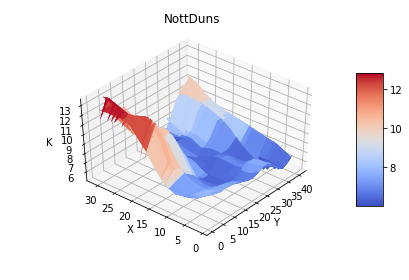

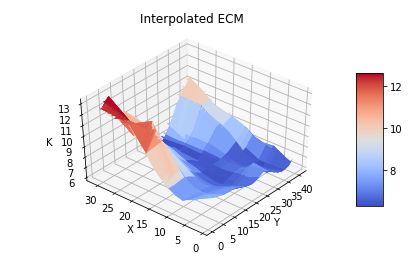

In [22]:
XX = train_data[['X','Y']].values
yy = train_data['Temp'].values

x = XX[:, 0]
y = XX[:, 1]
X, Y = np.meshgrid(x, y)

XY = np.array([X.ravel(), Y.ravel()]).T

# Sensor 41 location
S41 = loc_df.loc[41].values.reshape(-1, 2)

## Interpolated

interpol = Kriging(variogram_model='spherical')
interpol.fit(XX, G_all.loc[41].values)
ECM42 = interpol.predict(XY).reshape(*X.shape)

## NottDuns kernel

nonStat = NottDuns(10, 1)
nonStat.fit(XX, yy, G_all.values)
Nott42 = nonStat.Kernel(S41, XY).reshape(*X.shape)

fig = plt.figure()

ax = fig.gca(projection = '3d')
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('K')
ax.set_title('NottDuns')

surf = ax.plot_surface(X, Y, Nott42, cmap='coolwarm')
fig.colorbar(surf, shrink=0.5, aspect=5, pad=-0.05)
ax.view_init(45, 220)
ax.dist = 13
plt.tight_layout()
plt.show()

fig = plt.figure()

ax = fig.gca(projection = '3d')
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('K')
ax.set_title('Interpolated ECM')

surf = ax.plot_surface(X, Y, ECM42, cmap='coolwarm')
fig.colorbar(surf, shrink=0.5, aspect=5, pad=-0.05)
ax.view_init(45, 220)
ax.dist = 13
plt.tight_layout()
plt.show()